<a href="https://colab.research.google.com/github/Prashant43226/Speech-Enhancement-/blob/main/speech_enhancement_saarthi_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import librosa
import pandas as pd
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import IPython.display as ipd
import librosa.display
import scipy
import glob
import numpy as np
import math
import warnings
import pickle
from sklearn.utils import shuffle
import zipfile
%load_ext tensorboard

In [ ]:
!wget 'cdn.daitan.com/dataset.zip'    #import the daitan dataset

--2021-01-30 22:04:45--  http://cdn.daitan.com/dataset.zip
Resolving cdn.daitan.com (cdn.daitan.com)... 65.8.186.118, 65.8.186.77, 65.8.186.25, ...
Connecting to cdn.daitan.com (cdn.daitan.com)|65.8.186.118|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://cdn.daitan.com/dataset.zip [following]
--2021-01-30 22:04:45--  https://cdn.daitan.com/dataset.zip
Connecting to cdn.daitan.com (cdn.daitan.com)|65.8.186.118|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1779066768 (1.7G) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   1.66G  72.3MB/s    in 25s     

2021-01-30 22:05:10 (68.4 MB/s) - ‘dataset.zip’ saved [1779066768/1779066768]



In [ ]:
dataset_file_name = './dataset.zip'
with zipfile.ZipFile(dataset_file_name, 'r') as zip_ref:
    zip_ref.extractall('./dataset')
path_to_dataset = "./dataset/tfrecords"

In [ ]:
train_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'train_*'))   ##training data file
val_tfrecords_filenames = glob.glob(os.path.join(path_to_dataset, 'val_*'))       ##validation data file

# suffle the file names for training
np.random.shuffle(train_tfrecords_filenames)
print("Training file names: ", train_tfrecords_filenames)
print("Validation file names: ", val_tfrecords_filenames)

Training file names:  ['./dataset/tfrecords/train_0.tfrecords']
Validation file names:  ['./dataset/tfrecords/val_0.tfrecords']


In [ ]:
windowLength = 256                        # window length is taken as 256 to calculate the 256 point STFT
overlap      = round(0.25 * windowLength) # overlap of 75%
ffTLength    = windowLength               
inputFs      = 48e3                       # input frequency 
fs           = 8e3                        #sampling frequency is taken as 8kHz
numFeatures  = ffTLength//2 + 1
numSegments  = 8
print("windowLength:",windowLength)
print("overlap:",overlap)
print("ffTLength:",ffTLength)
print("inputFs:",inputFs)
print("fs:",fs)
print("numFeatures:",numFeatures)
print("numSegments:",numSegments)

windowLength: 256
overlap: 64
ffTLength: 256
inputFs: 48000.0
fs: 8000.0
numFeatures: 129
numSegments: 8


In [ ]:
mozilla_basepath = "./dataset/en"                                ##dataset containing clean audio
UrbanSound8K_basepath = './dataset/UrbanSound8K'                 ##dataset containing noise

In [ ]:
##Short Time Fourier Transform for noise and clean audio

def tf_record_parser(record):
    keys_to_features = {
        "noise_stft_phase": tf.io.FixedLenFeature((), tf.string, default_value=""),
        'noise_stft_mag_features': tf.io.FixedLenFeature([], tf.string),
        "clean_stft_magnitude": tf.io.FixedLenFeature((), tf.string)
    }

    features = tf.io.parse_single_example(record, keys_to_features)

    noise_stft_mag_features = tf.io.decode_raw(features['noise_stft_mag_features'], tf.float32)
    clean_stft_magnitude = tf.io.decode_raw(features['clean_stft_magnitude'], tf.float32)
    noise_stft_phase = tf.io.decode_raw(features['noise_stft_phase'], tf.float32)

    # reshape input and annotation images
    noise_stft_mag_features = tf.reshape(noise_stft_mag_features, (129, 8, 1), name="noise_stft_mag_features")
    clean_stft_magnitude = tf.reshape(clean_stft_magnitude, (129, 1, 1), name="clean_stft_magnitude")
    noise_stft_phase = tf.reshape(noise_stft_phase, (129,), name="noise_stft_phase")

    return noise_stft_mag_features, clean_stft_magnitude

In [ ]:
train_dataset = tf.data.TFRecordDataset([train_tfrecords_filenames])
train_dataset = train_dataset.map(tf_record_parser)
train_dataset = train_dataset.shuffle(8192)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(512)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
test_dataset = tf.data.TFRecordDataset([val_tfrecords_filenames])
test_dataset = test_dataset.map(tf_record_parser)
test_dataset = test_dataset.repeat(1)
test_dataset = test_dataset.batch(512)

  **TRAIN THE MODEL**

In [ ]:
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, Flatten, Dense, Reshape, Conv2DTranspose, BatchNormalization, Activation 
from tensorflow.keras import Model, backend

In [ ]:
##This model is inspired from U-Net and CR-CED(Cascaded Redundant -Convolutional Encoder Decoder)  
##It consists of 8 Convolutional Layers along with Skip Connections in between with a Leaky ReLU activation function and Batch Normalization
##The model calculates the RMSE loss and uses the Adams Optimizer
 
def build_model(l2_strength):
  
  inputs = Input(shape=[numFeatures,numSegments,1])
  x = inputs

  # -----

  x = tf.keras.layers.ZeroPadding2D(((4,4), (0,0)))(x)
  x = Conv2D(filters=18, kernel_size=[9,8], strides=[1, 1], padding='valid', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(x)
  x = BatchNormalization()(x)

  skip0 = Conv2D(filters=30, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = Activation('relu')(skip0)
  x = BatchNormalization()(x)

  x = Conv2D(filters=32, kernel_size=[9,8], strides=[1,1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=64, kernel_size=[3,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  # -----
  skip1 = Conv2D(filters=64, kernel_size=[1,1], strides=[1, 1], padding='same', use_bias=False,
                 kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

 #----

  x = Conv2D(filters=32, kernel_size=[3,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  # ----
  x = Conv2D(filters=32, kernel_size=[5,1], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  x = Conv2D(filters=32, kernel_size=[9,8], strides=[1, 1], padding='same', use_bias=False,
              kernel_regularizer=tf.keras.regularizers.l2(l2_strength))(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.2)(x)

  # ----
  x = tf.keras.layers.SpatialDropout2D(0.2)(x)
  x = Conv2D(filters=1, kernel_size=[129,1], strides=[1, 1], padding='same')(x)

  model = Model(inputs=inputs, outputs=x)

  optimizer = tf.keras.optimizers.Adam(3e-4)
  #optimizer = RAdam(total_steps=10000, warmup_proportion=0.1, min_lr=3e-4)

  model.compile(optimizer=optimizer, loss='mse', 
                metrics=[tf.keras.metrics.RootMeanSquaredError('rmse')])
  return model

In [ ]:
##build the model
model = build_model(l2_strength=0.0)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 129, 8, 1)]       0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 137, 8, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 129, 1, 18)        1296      
_________________________________________________________________
activation (Activation)      (None, 129, 1, 18)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 129, 1, 18)        72        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 129, 1, 30)        2700      
_________________________________________________________________
activation_1 (Activation)    (None, 129, 1, 30)        0     

In [ ]:
! sudo apt install python-pydot python-pydot-ng graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
Suggested packages:
  python-pyparsing-doc
The following NEW packages will be installed:
  python-pydot python-pydot-ng python-pyparsing
0 upgraded, 3 newly installed, 0 to remove and 13 not upgraded.
Need to get 91.5 kB of archives.
After this operation, 443 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-pyparsing all 2.2.0+dfsg1-2 [52.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pydot all 1.2.3-1 [19.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pydot-ng all 1.0.0-3 [19.8 kB]
Fetched 91.5 kB in 0s (184 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 3.)
debconf

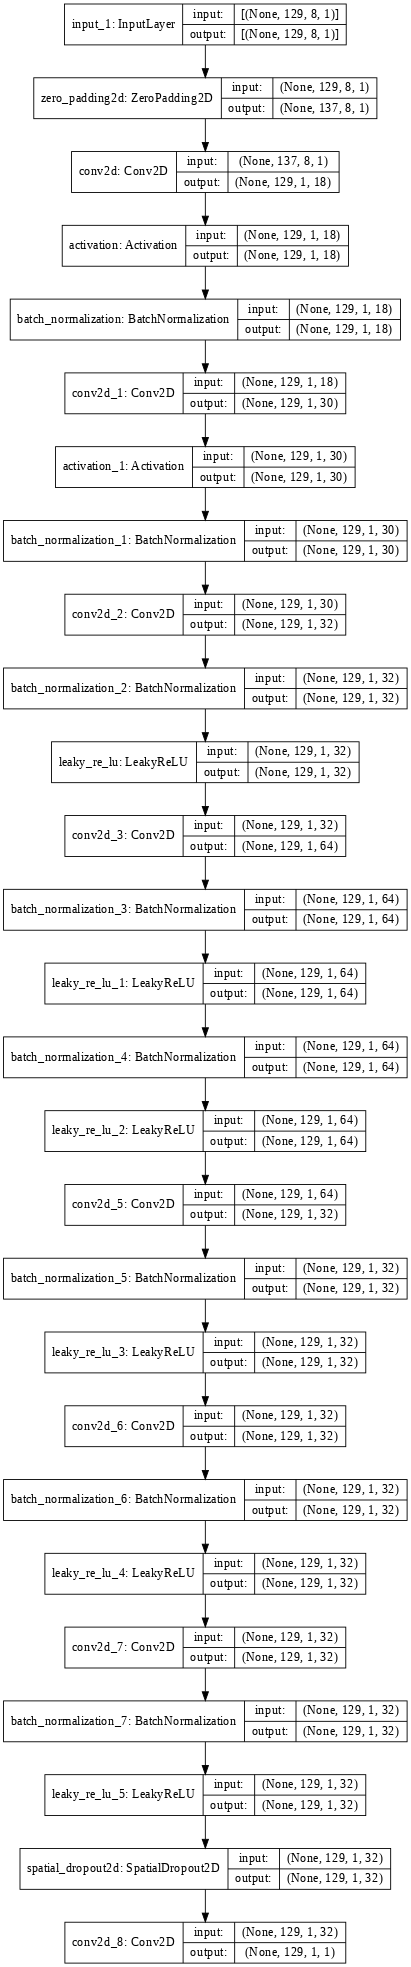

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
baseline_val_loss = model.evaluate(test_dataset)[0]
print(f"Baseline accuracy {baseline_val_loss}")

393/393 [==============================] - 326s 827ms/step - loss: 0.2603 - rmse: 0.5102
Baseline accuracy 0.2594604790210724


In [ ]:
##Please change the number of epochs and steps per epochs .

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True, baseline=None)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, update_freq='batch')
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='./denoiser_cnn_log_mel_generator.h5', 
                                                         monitor='val_loss', save_best_only=True)

model.fit(train_dataset,
         steps_per_epoch=40, # you might need to change this
         validation_data=test_dataset,
         epochs=100,          #you might need to change this
         callbacks=[early_stopping_callback, tensorboard_callback, checkpoint_callback]
        )

Epoch 1/100
40/40 [==============================] - 472s 12s/step - loss: 0.4232 - rmse: 0.6505 - val_loss: 0.2515 - val_rmse: 0.5015
Epoch 2/100
40/40 [==============================] - 471s 12s/step - loss: 0.2002 - rmse: 0.4474 - val_loss: 0.2326 - val_rmse: 0.4823
Epoch 3/100
40/40 [==============================] - 469s 12s/step - loss: 0.1868 - rmse: 0.4322 - val_loss: 0.2185 - val_rmse: 0.4674
Epoch 4/100
40/40 [==============================] - 468s 12s/step - loss: 0.1650 - rmse: 0.4063 - val_loss: 0.2059 - val_rmse: 0.4538
Epoch 5/100
40/40 [==============================] - 469s 12s/step - loss: 0.1754 - rmse: 0.4188 - val_loss: 0.1913 - val_rmse: 0.4374
Epoch 6/100
40/40 [==============================] - 471s 12s/step - loss: 0.1518 - rmse: 0.3897 - val_loss: 0.1819 - val_rmse: 0.4265
Epoch 7/100
40/40 [==============================] - 471s 12s/step - loss: 0.1454 - rmse: 0.3813 - val_loss: 0.1755 - val_rmse: 0.4190
Epoch 8/100
40/40 [==============================] - 46

In [ ]:
val_loss = model.evaluate(test_dataset)[0]
if val_loss < baseline_val_loss:
  print("New model saved.")
  model.save('./denoiser_cnn_log_mel_generator.h5')

NameError: ignored

**TEST THE MODEL**

In [ ]:
def read_audio(filepath, sample_rate, normalize=True):
    """Read an audio file and return it as a numpy array"""
    audio, sr = librosa.load(filepath, sr=sample_rate)
    if normalize:
      div_fac = 1 / np.max(np.abs(audio)) / 3.0
      audio = audio * div_fac
    return audio, sr
        
def add_noise_to_clean_audio(clean_audio, noise_signal):
    """Adds noise to an audio sample"""
    if len(clean_audio) >= len(noise_signal):
        # print("The noisy signal is smaller than the clean audio input. Duplicating the noise.")
        while len(clean_audio) >= len(noise_signal):
            noise_signal = np.append(noise_signal, noise_signal)

    ## Extract a noise segment from a random location in the noise file
    ind = np.random.randint(0, noise_signal.size - clean_audio.size)

    noiseSegment = noise_signal[ind: ind + clean_audio.size]

    speech_power = np.sum(clean_audio ** 2)
    noise_power = np.sum(noiseSegment ** 2)
    noisyAudio = clean_audio + np.sqrt(speech_power / noise_power) * noiseSegment
    return noisyAudio

def play(audio, sample_rate):
    ipd.display(ipd.Audio(data=audio, rate=sample_rate))

In [ ]:
##Use librosa to get Short Time Fourier Transform spectrogram 
class FeatureExtractor:
    def __init__(self, audio, *, windowLength, overlap, sample_rate):
        self.audio = audio
        self.ffT_length = windowLength
        self.window_length = windowLength
        self.overlap = overlap
        self.sample_rate = sample_rate
        self.window = scipy.signal.hamming(self.window_length, sym=False)

    def get_stft_spectrogram(self):
        return librosa.stft(self.audio, n_fft=self.ffT_length, win_length=self.window_length, hop_length=self.overlap,
                            window=self.window, center=True)

    def get_audio_from_stft_spectrogram(self, stft_features):
        return librosa.istft(stft_features, win_length=self.window_length, hop_length=self.overlap,
                             window=self.window, center=True)

    def get_mel_spectrogram(self):
        return librosa.feature.melspectrogram(self.audio, sr=self.sample_rate, power=2.0, pad_mode='reflect',
                                           n_fft=self.ffT_length, hop_length=self.overlap, center=True)

    def get_audio_from_mel_spectrogram(self, M):
        return librosa.feature.inverse.mel_to_audio(M, sr=self.sample_rate, n_fft=self.ffT_length, hop_length=self.overlap,
                                             win_length=self.window_length, window=self.window,
                                             center=True, pad_mode='reflect', power=2.0, n_iter=32, length=None)

In [ ]:
##Listen to the clean audio
cleanAudio, sr = read_audio(os.path.join(mozilla_basepath, 'test', 'common_voice_en_16526.mp3'), sample_rate=fs)
print("Min:", np.min(cleanAudio),"Max:",np.max(cleanAudio))
ipd.Audio(data=cleanAudio, rate=sr)

In [ ]:
##Listen to the noise
noiseAudio, sr = read_audio(os.path.join(UrbanSound8K_basepath, 'test', '7913-3-0-0.wav'), sample_rate=fs)
print("Min:", np.min(noiseAudio),"Max:",np.max(noiseAudio))
ipd.Audio(data=noiseAudio, rate=sr) 

In [ ]:
cleanAudioFeatureExtractor = FeatureExtractor(cleanAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
stft_features = cleanAudioFeatureExtractor.get_stft_spectrogram()
stft_features = np.abs(stft_features)
print("Min:", np.min(stft_features),"Max:",np.max(stft_features))

In [ ]:
##Listen to the clean audio+noise
noisyAudio = add_noise_to_clean_audio(cleanAudio, noiseAudio)
ipd.Audio(data=noisyAudio, rate=fs) 

In [ ]:
def prepare_input_features(stft_features):
    # Phase Aware Scaling: To avoid extreme differences (more than
    # 45 degree) between the noisy and clean phase, the clean spectral magnitude was encoded as similar to [21]:
    noisySTFT = np.concatenate([stft_features[:,0:numSegments-1], stft_features], axis=1)
    stftSegments = np.zeros((numFeatures, numSegments , noisySTFT.shape[1] - numSegments + 1))

    for index in range(noisySTFT.shape[1] - numSegments + 1):
        stftSegments[:,:,index] = noisySTFT[:,index:index + numSegments]
    return stftSegments

In [ ]:

noiseAudioFeatureExtractor = FeatureExtractor(noisyAudio, windowLength=windowLength, overlap=overlap, sample_rate=sr)
noise_stft_features = noiseAudioFeatureExtractor.get_stft_spectrogram()

# At reconstruction, noisy spectral phase was used instead to
# perform in- verse STFT and recover human speech.

noisyPhase = np.angle(noise_stft_features)
print(noisyPhase.shape)
noise_stft_features = np.abs(noise_stft_features)

mean = np.mean(noise_stft_features)
std = np.std(noise_stft_features)
noise_stft_features = (noise_stft_features - mean) / std

In [ ]:
predictors = prepare_input_features(noise_stft_features)

In [ ]:

predictors = np.reshape(predictors, (predictors.shape[0], predictors.shape[1], 1, predictors.shape[2]))
predictors = np.transpose(predictors, (3, 0, 1, 2)).astype(np.float32)
print('predictors.shape:', predictors.shape)

In [ ]:
STFTmodel = model.predict(predictors)
print(STFTmodel.shape)

In [ ]:
def revert_features_to_audio(features, phase, cleanMean=None, cleanStd=None):
    # scale the outpus back to the original range
    if cleanMean and cleanStd:
        features = cleanStd * features + cleanMean

    phase = np.transpose(phase, (1, 0))
    features = np.squeeze(features)

    # features = librosa.db_to_power(features)
    features = features * np.exp(1j * phase)  # that fixes the abs() ope previously done

    features = np.transpose(features, (1, 0))
    return noiseAudioFeatureExtractor.get_audio_from_stft_spectrogram(features)

In [ ]:
##Final denoised audio 
denoisedAudio = revert_features_to_audio(STFTmodel, noisyPhase, mean, std)
print("Min:", np.min(denoisedAudio),"Max:",np.max(denoisedAudio))
ipd.Audio(data=denoisedAudio, rate=fs) 

In [ ]:

plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(cleanAudio)
plt.title("Clean Audio")

plt.subplot(3,1,2)
plt.plot(noisyAudio)
plt.title("Noisy Audio")

plt.subplot(3,1,3)
plt.plot(denoisedAudio)
plt.title("Denoised Audio")

In [ ]:
##Function to get spectrogram
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)

  return spectrogram

In [ ]:
spectrogram_clean = get_spectrogram(noiseAudio)
spectrogram_noise=get_spectrogram(cleanAudio)
spectrogram_denoised_audio=get_spectrogram(denoisedAudioFullyConvolutional)

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(3,1,1)
plt.plot(spectrogram_clean)
plt.title("Clean Audio")

plt.subplot(3,1,2)
plt.plot(spectrogram_noise)
plt.title("Noisy Audio")

plt.subplot(3,1,3)
plt.plot(spectrogram_denoised_audio)
plt.title("Denoised Audio")
